# 1. Introduction

In this lab, you will learn how to do stock price prediction using LSTM (don't get too happy, because there is a random component to it you cannot predict which resembles more a random walk), perform movie classification, and generate random texts.

In [ ]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [ ]:
!pip install yfinance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import random
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Stock Price Classification

In this first part, you will try to predict stock prices of any company. Instead of doing a prediction, you will try to classify stocks as `strong_buy`, `buy`, `neutral`, `sell`, `strong_sell`, if the price in the next day closed $>5\%$, between $1\%$ and $5\%$, within $-1\%$ and $1\%$, between $-1\%$ and $-5\%$, and more than $-5\%$, respectively.

In [ ]:
stock_ticket = 'AMD'
stock = yf.download(stock_ticket, start='2018-01-01', end='2024-12-31', progress=False)
stock.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2018-01-02,10.98,11.02,10.34,10.42,44146300
2018-01-03,11.55,12.14,11.36,11.61,154066700
2018-01-04,12.12,12.43,11.97,12.10,109503000
2018-01-05,11.88,12.22,11.66,12.19,63808900
2018-01-08,12.28,12.30,11.85,12.01,63346000


In [ ]:
stock.tail()

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2024-12-23,124.599998,126.339996,120.470001,120.709999,47777900
2024-12-24,126.290001,127.510002,124.660004,127.510002,24829600
2024-12-26,125.059998,127.300003,125.050003,125.519997,24998200
2024-12-27,125.190002,126.180000,122.260002,124.370003,32924000
2024-12-30,122.440002,124.099998,122.349998,123.559998,30501600


Let's first only consider the closing values of the stock prices.

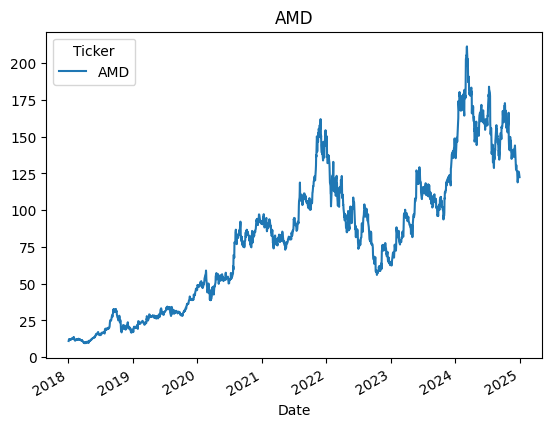

In [ ]:
stock.Close.plot()
plt.title(stock_ticket)
plt.show()

In [ ]:
stock_close = stock.Close

In [ ]:
stock_close.head()

Ticker,AMD
Date,
2018-01-02,10.98
2018-01-03,11.55
2018-01-04,12.12
2018-01-05,11.88
2018-01-08,12.28


Now, let's consider the percent change of the next value with respect to the current value of the stock. Note that the last entry using `diff(-1)` will be `not a number`, because there is nothing to compare againt.

In [ ]:
stock_next = -stock_close.diff(-1) / stock_close
stock_next.columns = ['Next']

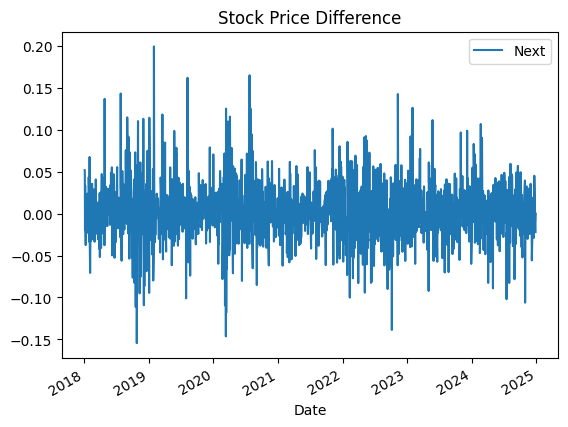

In [ ]:
stock_next.plot()
plt.title('Stock Price Difference')
plt.show()

In [ ]:
std = np.std(stock_next.values[:-1])
std

0.034200852181177153

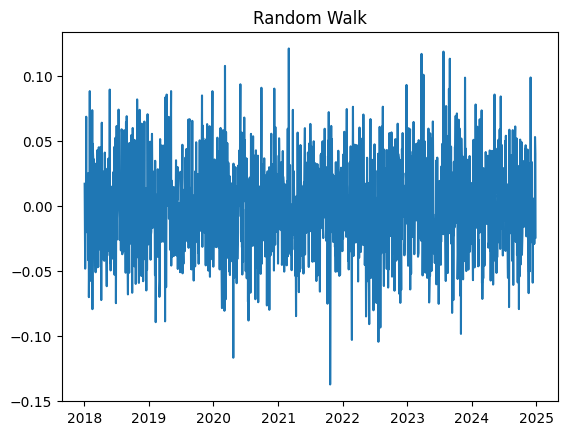

In [ ]:
r = np.random.normal(0, std, size=len(stock_next[:-1]))
plt.plot(stock_next.index[:-1], r)
plt.title('Random Walk')
plt.show()

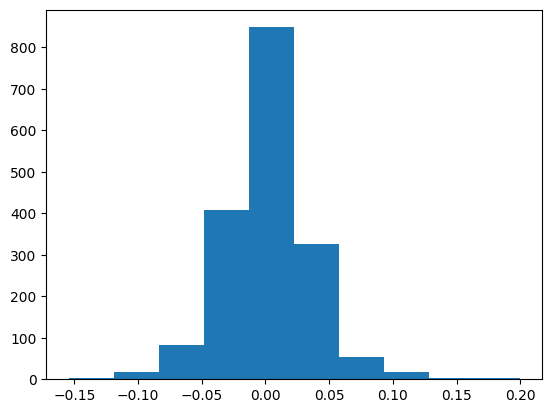

In [ ]:
plt.hist(stock_next.values, bins=10)
plt.show()

In [ ]:
stock_next.head()

,Next
Date,
2018-01-02,0.051913
2018-01-03,0.049351
2018-01-04,-0.019802
2018-01-05,0.033670
2018-01-08,-0.037459


In [ ]:
stock_next.tail()

,Next
Date,
2024-12-23,0.013563
2024-12-24,-0.009740
2024-12-26,0.001040
2024-12-27,-0.021967
2024-12-30,NaN


Because the last entry is `not-a-number`, let's remove the last entry and create the following class values:

In [ ]:
last_date = stock_close.index[-1]
last_date

Timestamp('2024-12-30 00:00:00')

In [ ]:
stock_close = stock_close.iloc[:-1]
stock_next = stock_next.iloc[:-1]
stock_next.tail()

,Next
Date,
2024-12-20,0.045214
2024-12-23,0.013563
2024-12-24,-0.009740
2024-12-26,0.001040
2024-12-27,-0.021967


Now, we will create the following classifications:

- 0: strong sell
- 1: sell
- 2: neutral
- 3: buy
- 4: strong buy

In [ ]:
values = stock_next.values
action = np.where(
    np.abs(values) > 0.05,
    np.sign(values) * 2,
    np.where(
        np.abs(values) > 0.01,
        np.sign(values) * 1,
        0
    )
).astype(np.int32)

action

array([[ 2],
       [ 1],
       [-1],
       ...,
       [ 0],
       [ 0],
       [-1]], dtype=int32)

Note that `action` is still shifted by 2 from the values obtained before, so we can just add `2` to it.

In [ ]:
classes = 5

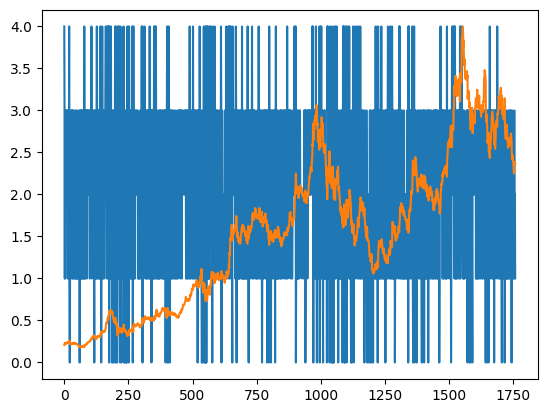

In [ ]:
plt.plot(np.arange(len(action)), action + (classes - 3))
plt.plot(np.arange(len(stock_close)), 4*stock_close / np.max(stock_close))

Let's create a training window where we can use LSTM to predict our classifier.

In [ ]:
def split_data(data, action, window=1, validation_split=0.1):
    x = []
    y = []
    for i in range(window, len(data)):
        x.append(data[i-window:i])
        y.append(action[i])

    train_size = int((1 - validation_split) * len(x))

    x = np.array(x)
    y = np.array(y)

    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]

In [ ]:
data = values

data = stock_close.values
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

classes = len(np.unique(action))

x_train, y_train, x_test, y_test = split_data(
    data, action + (classes-3), window=20, validation_split=0.1)

print(classes, np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, num_classes=classes)
y_test = keras.utils.to_categorical(y_test, num_classes=classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

5 [0 1 2 3 4]


((1565, 20), (1565, 5), (174, 20), (174, 5))

Now, you can create your network to try to predict wheather we should buy or sell stocks.

In [ ]:
def CreateModel(i_shape, o_shape):
  x_i = keras.layers.Input(i_shape)

  x = keras.layers.Dense(128, activation='relu')(x_i)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)

  return keras.models.Model(x_i, x)

optimizer = keras.optimizers.Adam(0.00001)
model = CreateModel(x_train.shape[1:], y_train.shape[1:])
model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 304,005 (1.16 MB)

 Trainable params: 304,005 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
          verbose=True, validation_data=(x_test, y_test))

Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.2192 - loss: 1.6185 - val_acc: 0.3391 - val_loss: 1.5385
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2638 - loss: 1.5962 - val_acc: 0.3391 - val_loss: 1.5024
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2967 - loss: 1.5732 - val_acc: 0.3391 - val_loss: 1.4706
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3017 - loss: 1.5559 - val_acc: 0.3391 - val_loss: 1.4465
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2742 - loss: 1.5411 - val_acc: 0.3391 - val_loss: 1.4272
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2541 - loss: 1.5393 - val_acc: 0.3391 - val_loss: 1.4099
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2874 - loss: 1.5309 - val_acc: 0.3391 - val_loss: 1.3959
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2964 - loss: 1.5179 - val_acc: 0.3391 - val_loss: 1.3838
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.288

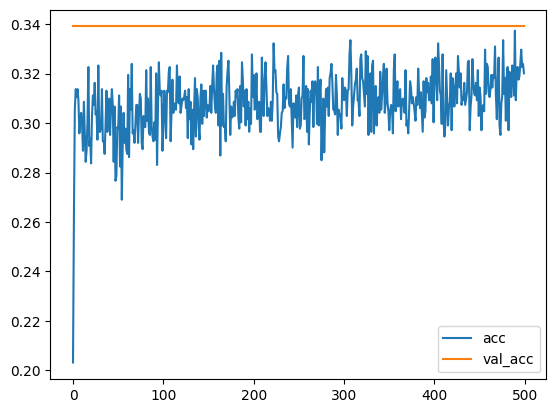

In [ ]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.3058 - loss: 1.4390
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - acc: 0.3378 - loss: 1.3909


([1.4259757995605469, 0.3214057385921478],
 [1.391433596611023, 0.33908045291900635])

In [ ]:
p_test = model.predict(x_test)
p_train = model.predict(x_train)
print('distribution of classes:', np.sum(y_train, axis=0))
print('acc of model:', np.mean(np.argmax(y_test, axis=1) == np.argmax(p_test, axis=1), axis=0))
y_v = np.argmax(y_train, axis=1)
p_v = np.argmax(p_train, axis=1)

# we will check if at least we got the signs correctly

def get_misses_per_class(y, p):
    y_v = np.argmax(y, axis=1).astype(np.int16)
    p_v = np.argmax(p, axis=1).astype(np.int16)

    y_s = y_v - (classes - 3)
    p_s = p_v - (classes - 3)

    hits = {c - (classes-3) : 0 for c in range(classes) }
    total = {c - (classes-3): 0 for c in range(classes) }

    for i in range(len(y_s)):
        hits[y_s[i]] += (y_s[i] == p_s[i])
        total[y_s[i]] += 1

    for k in total:
        print(k, 'hits:', hits[k], 'total:', total[k], 'acc:', hits[k]/total[k])


print('train')
get_misses_per_class(y_train, p_train)
print('test')
get_misses_per_class(y_test, p_test)
print(list(zip(np.argmax(y_test, axis=-1), np.argmax(p_test, axis=-1))))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
distribution of classes: [ 88. 424. 476. 460. 117.]
acc of model: 0.3390804597701149
train
-2 hits: 0 total: 88 acc: 0.0
-1 hits: 14 total: 424 acc: 0.0330188679245283
0 hits: 389 total: 476 acc: 0.8172268907563025
1 hits: 100 total: 460 acc: 0.21739130434782608
2 hits: 0 total: 117 acc: 0.0
test
-2 hits: 0 total: 8 acc: 0.0
-1 hits: 0 total: 48 acc: 0.0
0 hits: 59 total: 59 acc: 1.0
1 hits: 0 total: 57 acc: 0.0
2 hits: 0 total: 2 acc: 0.0
[(3, 2), (2, 2), (3, 2), (3, 2), (3, 2), (1, 2), (0, 2), (3, 2), (3, 2), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (3, 2), (3, 2), (3, 2), (3, 2), (3, 2), (1, 2), (2, 2), (1, 2), (3, 2), (3, 2), (1, 2), (2, 2), (2, 2), (1, 2), (1, 2), (3, 2), (2, 2), (2, 2), (1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (1, 2), (3, 2), (2, 2), (2, 2), (2, 2), (1, 2), (3, 2), (3, 2), (1, 2), (3, 2), (2, 2), (3, 2), (3, 2), (2, 2), (3, 2), (1, 2), (2, 2), (2, 2), (1, 2), (0, 2), (1, 2)

Not very impressive, as the majority of the time we are just predicting do not do anything. Also, our prediction for upward movements almost never got it right.

Now, it is your turn to try to improve our stock prediction using LSTM's or GRUs.

Another good datapoint is the following. In most of the cases, a good classifier needs to beat the previous day prediction as well.

In [ ]:
acc_previous_day = 0
movement_right = 0

p_train[1:] = y_train[0:-1]
p_test[0] = y_train[-1]
p_test[1:] = y_test[0:-1]

print('train')
get_misses_per_class(y_train, p_train)
print('test')
get_misses_per_class(y_test, p_test)

train
-2 hits: 5 total: 88 acc: 0.056818181818181816
-1 hits: 124 total: 424 acc: 0.29245283018867924
0 hits: 151 total: 476 acc: 0.3172268907563025
1 hits: 135 total: 460 acc: 0.29347826086956524
2 hits: 13 total: 117 acc: 0.1111111111111111
test
-2 hits: 0 total: 8 acc: 0.0
-1 hits: 11 total: 48 acc: 0.22916666666666666
0 hits: 23 total: 59 acc: 0.3898305084745763
1 hits: 22 total: 57 acc: 0.38596491228070173
2 hits: 0 total: 2 acc: 0.0


In [ ]:
print(np.argmax(y_train[:20], axis=-1))
print(np.argmax(p_train[:20], axis=-1))

[1 0 0 2 2 1 2 3 2 3 2 1 3 1 3 3 3 2 1 1]
[2 1 0 0 2 2 1 2 3 2 3 2 1 3 1 3 3 3 2 1]


In [ ]:
def CreateLSTMModel(i_shape, o_shape, num_features):
  x_i = keras.layers.Input(shape=(i_shape, num_features))
  x = keras.layers.LSTM(32, return_sequences=True)(x_i)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.LSTM(32, return_sequences=False)(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(16, activation='relu')(x)
  x = keras.layers.Dense(o_shape, activation='softmax')(x)

  return keras.models.Model(x_i, x)

optimizer = keras.optimizers.Adam(0.00001)
model = CreateLSTMModel(x_train.shape[1], y_train.shape[1], 1)
model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,285 (51.89 KB)

 Trainable params: 13,285 (51.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    f'best_AMD_model.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.1996 - loss: 1.6059

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.2017 - loss: 1.6060 - val_acc: 0.3391 - val_loss: 1.5845
Epoch 2/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2147 - loss: 1.6038

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.2157 - loss: 1.6038 - val_acc: 0.3391 - val_loss: 1.5730
Epoch 3/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2557 - loss: 1.6025

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2530 - loss: 1.6026 - val_acc: 0.3391 - val_loss: 1.5621
Epoch 4/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2339 - loss: 1.6010

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2340 - loss: 1.6009 - val_acc: 0.3391 - val_loss: 1.5513
Epoch 5/200
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2564 - loss: 1.5942

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2560 - loss: 1.5943 - val_acc: 0.3391 - val_loss: 1.5412
Epoch 6/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2761 - loss: 1.5916

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.2752 - loss: 1.5919 - val_acc: 0.3391 - val_loss: 1.5318
Epoch 7/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2841 - loss: 1.5891

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2823 - loss: 1.5894 - val_acc: 0.3391 - val_loss: 1.5220
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2830 - loss: 1.5883

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2827 - loss: 1.5883 - val_acc: 0.3391 - val_loss: 1.5137
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2574 - loss: 1.5885

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2574 - loss: 1.5885 - val_acc: 0.3391 - val_loss: 1.5050
Epoch 10/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2484 - loss: 1.5822

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2513 - loss: 1.5822 - val_acc: 0.3391 - val_loss: 1.4975
Epoch 11/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3008 - loss: 1.5772

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2997 - loss: 1.5774 - val_acc: 0.3391 - val_loss: 1.4898
Epoch 12/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2955 - loss: 1.5803

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2930 - loss: 1.5802 - val_acc: 0.3391 - val_loss: 1.4828
Epoch 13/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2989 - loss: 1.5719

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2986 - loss: 1.5720 - val_acc: 0.3391 - val_loss: 1.4755
Epoch 14/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2837 - loss: 1.5727

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2838 - loss: 1.5728 - val_acc: 0.3391 - val_loss: 1.4703
Epoch 15/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.2915 - loss: 1.5678

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.2915 - loss: 1.5679 - val_acc: 0.3391 - val_loss: 1.4651
Epoch 16/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2868 - loss: 1.5736

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2868 - loss: 1.5736 - val_acc: 0.3391 - val_loss: 1.4603
Epoch 17/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2560 - loss: 1.5682

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2570 - loss: 1.5683 - val_acc: 0.3391 - val_loss: 1.4553
Epoch 18/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2881 - loss: 1.5652

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2880 - loss: 1.5652 - val_acc: 0.3391 - val_loss: 1.4507
Epoch 19/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2960 - loss: 1.5594

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2949 - loss: 1.5599 - val_acc: 0.3391 - val_loss: 1.4458
Epoch 20/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2970 - loss: 1.5572

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2960 - loss: 1.5577 - val_acc: 0.3391 - val_loss: 1.4413
Epoch 21/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2951 - loss: 1.5600

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2950 - loss: 1.5600 - val_acc: 0.3391 - val_loss: 1.4366
Epoch 22/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2813 - loss: 1.5587

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2816 - loss: 1.5584 - val_acc: 0.3391 - val_loss: 1.4321
Epoch 23/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2929 - loss: 1.5525

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2927 - loss: 1.5525 - val_acc: 0.3391 - val_loss: 1.4278
Epoch 24/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2876 - loss: 1.5584

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2874 - loss: 1.5580 - val_acc: 0.3391 - val_loss: 1.4235
Epoch 25/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2658 - loss: 1.5582

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2688 - loss: 1.5572 - val_acc: 0.3391 - val_loss: 1.4192
Epoch 26/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2864 - loss: 1.5465

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2864 - loss: 1.5470 - val_acc: 0.3391 - val_loss: 1.4151
Epoch 27/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2780 - loss: 1.5558

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2782 - loss: 1.5556 - val_acc: 0.3391 - val_loss: 1.4117
Epoch 28/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2811 - loss: 1.5422

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2812 - loss: 1.5423 - val_acc: 0.3391 - val_loss: 1.4080
Epoch 29/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3003 - loss: 1.5377

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3001 - loss: 1.5377 - val_acc: 0.3391 - val_loss: 1.4042
Epoch 30/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2949 - loss: 1.5452

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2949 - loss: 1.5451 - val_acc: 0.3391 - val_loss: 1.4010
Epoch 31/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2833 - loss: 1.5411

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2836 - loss: 1.5410 - val_acc: 0.3391 - val_loss: 1.3981
Epoch 32/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2907 - loss: 1.5442

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2903 - loss: 1.5429 - val_acc: 0.3391 - val_loss: 1.3951
Epoch 33/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.2835 - loss: 1.5304

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.2837 - loss: 1.5308 - val_acc: 0.3391 - val_loss: 1.3926
Epoch 34/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.2702 - loss: 1.5421

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.2710 - loss: 1.5418 - val_acc: 0.3391 - val_loss: 1.3899
Epoch 35/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2971 - loss: 1.5236

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2970 - loss: 1.5238 - val_acc: 0.3391 - val_loss: 1.3876
Epoch 36/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2844 - loss: 1.5282

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2842 - loss: 1.5285 - val_acc: 0.3391 - val_loss: 1.3857
Epoch 37/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2825 - loss: 1.5310

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2828 - loss: 1.5310 - val_acc: 0.3391 - val_loss: 1.3836
Epoch 38/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2934 - loss: 1.5232

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2936 - loss: 1.5232 - val_acc: 0.3391 - val_loss: 1.3815
Epoch 39/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2950 - loss: 1.5154

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2948 - loss: 1.5156 - val_acc: 0.3391 - val_loss: 1.3795
Epoch 40/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2795 - loss: 1.5273

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2803 - loss: 1.5267 - val_acc: 0.3391 - val_loss: 1.3780
Epoch 41/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3149 - loss: 1.5189

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3124 - loss: 1.5192 - val_acc: 0.3391 - val_loss: 1.3764
Epoch 42/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2818 - loss: 1.5307

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2819 - loss: 1.5305 - val_acc: 0.3391 - val_loss: 1.3747
Epoch 43/200
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2824 - loss: 1.5131

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.2833 - loss: 1.5133 - val_acc: 0.3391 - val_loss: 1.3729
Epoch 44/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2890 - loss: 1.5167

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2889 - loss: 1.5166 - val_acc: 0.3391 - val_loss: 1.3715
Epoch 45/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2936 - loss: 1.5059

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.2934 - loss: 1.5063 - val_acc: 0.3391 - val_loss: 1.3699
Epoch 46/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3150 - loss: 1.5025

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3118 - loss: 1.5041 - val_acc: 0.3391 - val_loss: 1.3687
Epoch 47/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2830 - loss: 1.5138

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.2841 - loss: 1.5136 - val_acc: 0.3391 - val_loss: 1.3676
Epoch 48/200
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2903 - loss: 1.5032

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2906 - loss: 1.5041 - val_acc: 0.3391 - val_loss: 1.3662
Epoch 49/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2835 - loss: 1.5166

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2836 - loss: 1.5158 - val_acc: 0.3391 - val_loss: 1.3651
Epoch 50/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2865 - loss: 1.5232

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2871 - loss: 1.5218 - val_acc: 0.3391 - val_loss: 1.3641
Epoch 51/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3130 - loss: 1.5012

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3121 - loss: 1.5016 - val_acc: 0.3391 - val_loss: 1.3632
Epoch 52/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3020 - loss: 1.4883

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.3016 - loss: 1.4889 - val_acc: 0.3391 - val_loss: 1.3622
Epoch 53/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.2777 - loss: 1.5204

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.2782 - loss: 1.5201 - val_acc: 0.3391 - val_loss: 1.3612
Epoch 54/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.2636 - loss: 1.5273

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - acc: 0.2653 - loss: 1.5258 - val_acc: 0.3391 - val_loss: 1.3602
Epoch 55/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3015 - loss: 1.5313

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3005 - loss: 1.5275 - val_acc: 0.3391 - val_loss: 1.3594
Epoch 56/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2961 - loss: 1.4938

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2964 - loss: 1.4946 - val_acc: 0.3391 - val_loss: 1.3584
Epoch 57/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2832 - loss: 1.5030

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2835 - loss: 1.5028 - val_acc: 0.3391 - val_loss: 1.3575
Epoch 58/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3193 - loss: 1.4921

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3159 - loss: 1.4927 - val_acc: 0.3391 - val_loss: 1.3568
Epoch 59/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3007 - loss: 1.5002

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3015 - loss: 1.4994 - val_acc: 0.3391 - val_loss: 1.3559
Epoch 60/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2924 - loss: 1.5071

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2925 - loss: 1.5069 - val_acc: 0.3391 - val_loss: 1.3551
Epoch 61/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2971 - loss: 1.5031

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2972 - loss: 1.5030 - val_acc: 0.3391 - val_loss: 1.3543
Epoch 62/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2993 - loss: 1.4878

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2979 - loss: 1.4882 - val_acc: 0.3391 - val_loss: 1.3536
Epoch 63/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3029 - loss: 1.4965

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3024 - loss: 1.4957 - val_acc: 0.3391 - val_loss: 1.3527
Epoch 64/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2798 - loss: 1.4970

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2802 - loss: 1.4968 - val_acc: 0.3391 - val_loss: 1.3517
Epoch 65/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2815 - loss: 1.4999

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2819 - loss: 1.4998 - val_acc: 0.3391 - val_loss: 1.3509
Epoch 66/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2550 - loss: 1.4979

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2556 - loss: 1.4979 - val_acc: 0.3391 - val_loss: 1.3501
Epoch 67/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3037 - loss: 1.4835

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.3030 - loss: 1.4839 - val_acc: 0.3391 - val_loss: 1.3493
Epoch 68/200
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.3051 - loss: 1.4770

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.3043 - loss: 1.4776 - val_acc: 0.3391 - val_loss: 1.3486
Epoch 69/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.3042 - loss: 1.4826

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.3036 - loss: 1.4826 - val_acc: 0.3391 - val_loss: 1.3477
Epoch 70/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3028 - loss: 1.4806

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3029 - loss: 1.4808 - val_acc: 0.3391 - val_loss: 1.3469
Epoch 71/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3202 - loss: 1.4857

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3185 - loss: 1.4859 - val_acc: 0.3391 - val_loss: 1.3463
Epoch 72/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2972 - loss: 1.4854

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2964 - loss: 1.4851 - val_acc: 0.3391 - val_loss: 1.3455
Epoch 73/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2970 - loss: 1.5070

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2974 - loss: 1.5040 - val_acc: 0.3391 - val_loss: 1.3448
Epoch 74/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2864 - loss: 1.4731

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2888 - loss: 1.4736 - val_acc: 0.3391 - val_loss: 1.3441
Epoch 75/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3112 - loss: 1.4691

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3083 - loss: 1.4707 - val_acc: 0.3391 - val_loss: 1.3435
Epoch 76/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3140 - loss: 1.4657

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3136 - loss: 1.4669 - val_acc: 0.3391 - val_loss: 1.3429
Epoch 77/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3052 - loss: 1.4854

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3049 - loss: 1.4845 - val_acc: 0.3391 - val_loss: 1.3422
Epoch 78/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2870 - loss: 1.4851

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2871 - loss: 1.4849 - val_acc: 0.3391 - val_loss: 1.3417
Epoch 79/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2802 - loss: 1.4769

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2806 - loss: 1.4769 - val_acc: 0.3391 - val_loss: 1.3412
Epoch 80/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3090 - loss: 1.4653

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3090 - loss: 1.4659 - val_acc: 0.3391 - val_loss: 1.3406
Epoch 81/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3009 - loss: 1.4747

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3008 - loss: 1.4746 - val_acc: 0.3391 - val_loss: 1.3401
Epoch 82/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2695 - loss: 1.4735

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2731 - loss: 1.4731 - val_acc: 0.3391 - val_loss: 1.3396
Epoch 83/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2894 - loss: 1.4725

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.2895 - loss: 1.4725 - val_acc: 0.3391 - val_loss: 1.3392
Epoch 84/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3062 - loss: 1.4616

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3048 - loss: 1.4629 - val_acc: 0.3391 - val_loss: 1.3388
Epoch 85/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2858 - loss: 1.4550

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2861 - loss: 1.4552 - val_acc: 0.3391 - val_loss: 1.3383
Epoch 86/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2958 - loss: 1.4718

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2953 - loss: 1.4717 - val_acc: 0.3391 - val_loss: 1.3379
Epoch 87/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2870 - loss: 1.4697

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.2876 - loss: 1.4696 - val_acc: 0.3391 - val_loss: 1.3374
Epoch 88/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2953 - loss: 1.4775

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2963 - loss: 1.4771 - val_acc: 0.3391 - val_loss: 1.3372
Epoch 89/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.3226 - loss: 1.4699

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.3224 - loss: 1.4699 - val_acc: 0.3391 - val_loss: 1.3368
Epoch 90/200
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.2938 - loss: 1.4713

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.2939 - loss: 1.4709 - val_acc: 0.3391 - val_loss: 1.3364
Epoch 91/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.2974 - loss: 1.4538

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.2977 - loss: 1.4545 - val_acc: 0.3391 - val_loss: 1.3360
Epoch 92/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2772 - loss: 1.4701

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.2776 - loss: 1.4700 - val_acc: 0.3391 - val_loss: 1.3359
Epoch 93/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3149 - loss: 1.4649

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3147 - loss: 1.4650 - val_acc: 0.3391 - val_loss: 1.3357
Epoch 94/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2812 - loss: 1.4825

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2833 - loss: 1.4799 - val_acc: 0.3391 - val_loss: 1.3355
Epoch 95/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2927 - loss: 1.4525

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2930 - loss: 1.4529 - val_acc: 0.3391 - val_loss: 1.3352
Epoch 96/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3068 - loss: 1.4646

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3057 - loss: 1.4643 - val_acc: 0.3391 - val_loss: 1.3351
Epoch 97/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3054 - loss: 1.4498

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3061 - loss: 1.4509 - val_acc: 0.3391 - val_loss: 1.3349
Epoch 98/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2979 - loss: 1.4563

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2980 - loss: 1.4566 - val_acc: 0.3391 - val_loss: 1.3346
Epoch 99/200
44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2959 - loss: 1.4719

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2961 - loss: 1.4703 - val_acc: 0.3391 - val_loss: 1.3345
Epoch 100/200
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2799 - loss: 1.4771

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2807 - loss: 1.4760 - val_acc: 0.3391 - val_loss: 1.3344
Epoch 101/200
43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.2864 - loss: 1.4717

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2893 - loss: 1.4695 - val_acc: 0.3391 - val_loss: 1.3341
Epoch 102/200
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3048 - loss: 1.4404

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3039 - loss: 1.4417 - val_acc: 0.3391 - val_loss: 1.3340
Epoch 103/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3083 - loss: 1.4551

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.3085 - loss: 1.4552 - val_acc: 0.3391 - val_loss: 1.3340
Epoch 104/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.2960 - loss: 1.4592

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2959 - loss: 1.4593 - val_acc: 0.3391 - val_loss: 1.3339
Epoch 105/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.3222 - loss: 1.4627 - val_acc: 0.3391 - val_loss: 1.3340
Epoch 106/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.3060 - loss: 1.4503 - val_acc: 0.3391 - val_loss: 1.3340
Epoch 107/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.3345 - loss: 1.4398

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.3335 - loss: 1.4404 - val_acc: 0.3391 - val_loss: 1.3337
Epoch 108/200
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.3249 - loss: 1.4413

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.3244 - loss: 1.4417 - val_acc: 0.3391 - val_loss: 1.3337
Epoch 109/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3143 - loss: 1.4578 - val_acc: 0.3391 - val_loss: 1.3338
Epoch 110/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3048 - loss: 1.4542 - val_acc: 0.3391 - val_loss: 1.3338
Epoch 111/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.2982 - loss: 1.4750 - val_acc: 0.3391 - val_loss: 1.3340
Epoch 112/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.3038 - loss: 1.4545 - val_acc: 0.3391 - val_loss: 1.3344
Epoch 113/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.2999 - loss: 1.4454 - val_acc: 0.3391 - val_loss: 1.3344
Epoch 114/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.3224 - loss: 1.4428 - val_acc: 0.3391 - val_loss: 1.3349
Epoch 115/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.2956 - loss: 1.4622 - val_acc: 0.3391 - val_loss: 1.3350
Epoch 116/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - ac

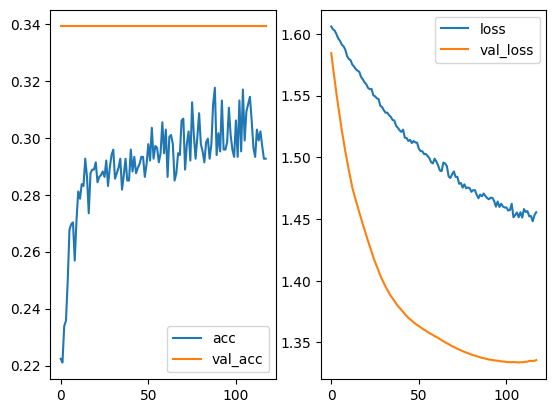

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Now, you will try to improve this result. You can try the following strategices: pick at least 2.

1. Create an embedding on the time series movement as shown in lecture 7: going down, going up, stable, $y = x^2$, $y = -x^2$. Feed that to an embedding that will "choose the best representation". Remember to adjust the data.

2. Perform analysis on multiple time scales and add them together at the end. For example, use daily closing values, moving average over the past 7 days (1 week), and over the past month. Create three models and do a Dense model "adding" them together for the final classifier.

3. Perform Google search, do sentiment analysis on the top $n$ results (look at the exercise below), and feed the sentiment vector to the deep learning model.

# **Strategy 1**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2831 - loss: 1.5707

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2824 - loss: 1.5699 - val_accuracy: 0.2543 - val_loss: 1.5256
Epoch 2/100
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2808 - loss: 1.4733

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2816 - loss: 1.4725 - val_accuracy: 0.2890 - val_loss: 1.3887
Epoch 3/100
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2946 - loss: 1.4177

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2949 - loss: 1.4184 - val_accuracy: 0.3353 - val_loss: 1.3669
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3295 - loss: 1.4226 - val_accuracy: 0.2948 - val_loss: 1.3784
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3293 - loss: 1.4263 - val_accuracy: 0.3006 - val_loss: 1.3749
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3313 - loss: 1.3937 - val_accuracy: 0.3064 - val_loss: 1.3703
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3245 - loss: 1.4182 - val_accuracy: 0.3064 - val_loss: 1.3768
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3375 - loss: 1.3832 - val_accuracy: 0.3006 - val_loss: 1.3742
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3440 - loss: 1.4056 - val_accuracy: 0.3121 - val_loss: 1.3713
Epoch 10/100
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3595 - loss: 1.3986

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3581 - loss: 1.3986 - val_accuracy: 0.3237 - val_loss: 1.3646
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3059 - loss: 1.3959 - val_accuracy: 0.2948 - val_loss: 1.3768
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3575 - loss: 1.3855 - val_accuracy: 0.2890 - val_loss: 1.3683
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3462 - loss: 1.3773 - val_accuracy: 0.3179 - val_loss: 1.3655
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3419 - loss: 1.3870 - val_accuracy: 0.3006 - val_loss: 1.3836
Epoch 15/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3529 - loss: 1.3770 - val_accuracy: 0.3295 - val_loss: 1.3715
Epoch 16/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3857 - loss: 1.3525 - val_accuracy: 0.3064 - val_loss: 1.3861
Epoch 17/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3681 - loss: 1.3428 - val_accuracy: 0.3295 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3906 - loss: 1.3435 - val_accuracy: 0.3526 - val_loss: 1.3637
Epoch 21/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3946 - loss: 1.3150 - val_accuracy: 0.3584 - val_loss: 1.3643
Epoch 22/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4135 - loss: 1.3004 - val_accuracy: 0.3468 - val_loss: 1.3760
Epoch 23/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4108 - loss: 1.2805 - val_accuracy: 0.3295 - val_loss: 1.3910
Epoch 24/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4259 - loss: 1.2583 - val_accuracy: 0.3237 - val_loss: 1.4406
Epoch 25/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4126 - loss: 1.2817 - val_accuracy: 0.3353 - val_loss: 1.4031
Epoch 26/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4545 - loss: 1.2422 - val_accuracy: 0.3295 - val_loss: 1.4098
Epoch 27/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4490 - loss: 1.2170 - val_accuracy: 0.3410 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


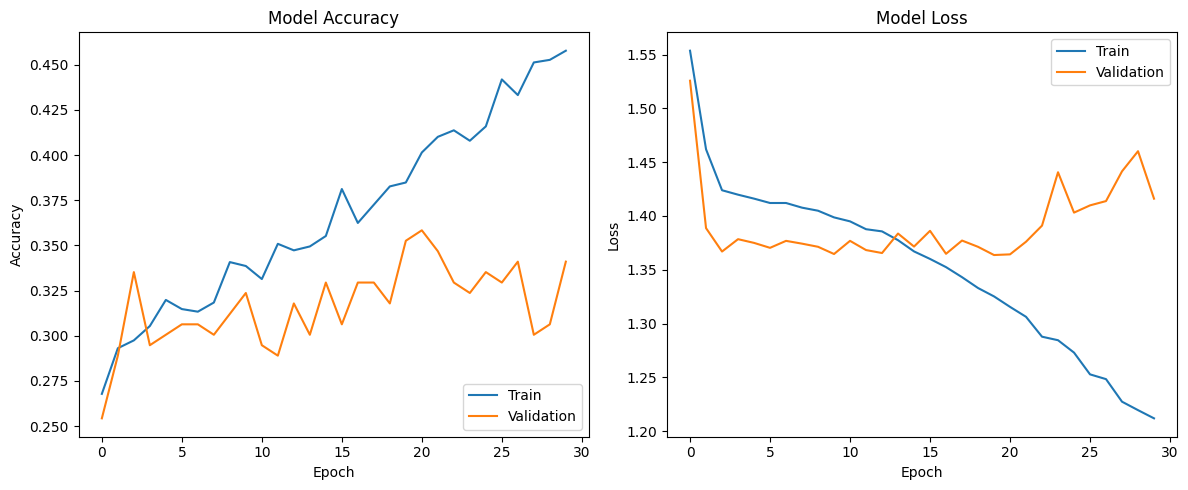

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.optimize import curve_fit

stock_ticker = 'AMD'
stock = yf.download(stock_ticker, start='2018-01-01', end='2024-12-31', progress=False)
stock_close = stock.Close
stock_next = -stock_close.diff(-1) / stock_close

values = stock_next.values
action = np.where(
    np.abs(values) > 0.05,
    np.sign(values) * 2,
    np.where(
        np.abs(values) > 0.01,
        np.sign(values) * 1,
        0
    )
).astype(np.int32)

# Map from [-2, -1, 0, 1, 2] to [0, 1, 2, 3, 4]
mapped_action = action + 2
classes = 5

# Normalization
scaler = StandardScaler()
scaled_close = scaler.fit_transform(stock_close.values.reshape(-1, 1)).flatten()

# Feature addition
scaled_volume = scaler.fit_transform(stock.Volume.values.reshape(-1, 1)).flatten()
stock['SMA5'] = stock_close.rolling(window=5).mean()
stock['SMA20'] = stock_close.rolling(window=20).mean()
scaled_sma5 = scaler.fit_transform(stock['SMA5'].fillna(0).values.reshape(-1, 1)).flatten()
scaled_sma20 = scaler.fit_transform(stock['SMA20'].fillna(0).values.reshape(-1, 1)).flatten()

# Combine features
all_features = np.column_stack((scaled_close, scaled_volume, scaled_sma5, scaled_sma20))

# Function to identify pattern in a window of time series
def identify_pattern(window, threshold=0.01):
    """
    Identify the pattern in a window of time series data

    Patterns:
    0: Stable (little change)
    1: Going up (linear uptrend)
    2: Going down (linear downtrend)
    3: Convex pattern (y = x²)
    4: Concave pattern (y = -x²)
    """
    # Normalization values
    min_val = np.min(window)
    max_val = np.max(window)
    range_val = max_val - min_val

    # If almost no change, classify as stable
    if range_val < threshold:
        return 0  # Stable

    # Normalization
    normalized = (window - min_val) / range_val if range_val > 0 else window - min_val

    x = np.linspace(0, 1, len(window))

    # For linear trend y = ax + b
    def linear(x, a, b):
        return a * x + b

    # For quadratic patterns y = ax^2 + bx + c
    def quadratic(x, a, b, c):
        return a * x**2 + b * x + c

    try:
        # Fit linear model
        linear_params, _ = curve_fit(linear, x, normalized)
        linear_slope = linear_params[0]

        # Fit quadratic model
        quad_params, _ = curve_fit(quadratic, x, normalized)
        quad_concavity = quad_params[0]

        # Calculate error for each model
        linear_pred = linear(x, linear_params[0], linear_params[1])
        linear_MSE = np.mean((normalized - linear_pred)**2)

        quad_pred = quadratic(x, quad_params[0], quad_params[1], quad_params[2])
        quad_MSE = np.mean((normalized - quad_pred)**2)

        # Determine which model fits better and the pattern
        if quad_MSE < linear_MSE * 0.7:
            if quad_concavity > 0.5:  # Strong positive quadratic term (convex)
                return 3  # Convex pattern (y = x²)
            elif quad_concavity < -0.5:  # Strong negative quadratic term (concave)
                return 4  # Concave pattern (y = -x²)

        # Linear is good enough
        if linear_slope > 0.3:
            return 1  # Slope upwards
        elif linear_slope < -0.3:
            return 2  # Slope downwards
        else:
            return 0  # Stable

    except:
        return 0

    return 0  # Default to stable

# Extract patterns from the time series
def extract_patterns(data, window_size=10):
    patterns = []
    for i in range(window_size, len(data)):
        window = data[i-window_size:i]
        pattern = identify_pattern(window)
        patterns.append(pattern)

    padding = [0] * window_size
    return np.array(padding + patterns)

# Extract patterns from close prices
pattern_sequence = extract_patterns(scaled_close, window_size=10)

# Modified function from before to also yield separate training, validation, and test sets as well as accomodate for pattern recognition.
def split_data_with_patterns(feature_data, labels, patterns, window=20, validation_split=0.1, test_split=0.1):
    x_features = []
    x_patterns = []
    y = []

    start_idx = 20

    for i in range(start_idx + window, len(feature_data)):
        x_features.append(feature_data[i-window:i])

        # Get pattern sequence for this window
        pattern_window = patterns[i-window:i]
        x_patterns.append(pattern_window)

        y.append(labels[i])

    x_features = np.array(x_features)
    x_patterns = np.array(x_patterns)
    y = np.array(y)

    # Calculate split points
    train_size = int((1 - validation_split - test_split) * len(x_features))
    val_size = int(validation_split * len(x_features))

    # Split data
    x_train_features = x_features[:train_size]
    x_train_patterns = x_patterns[:train_size]
    y_train = y[:train_size]

    x_val_features = x_features[train_size:train_size+val_size]
    x_val_patterns = x_patterns[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    x_test_features = x_features[train_size+val_size:]
    x_test_patterns = x_patterns[train_size+val_size:]
    y_test = y[train_size+val_size:]

    return (x_train_features, x_train_patterns, y_train,
            x_val_features, x_val_patterns, y_val,
            x_test_features, x_test_patterns, y_test)

window_size = 8
num_patterns = 5

(x_train_features, x_train_patterns, y_train,
 x_val_features, x_val_patterns, y_val,
 x_test_features, x_test_patterns, y_test) = split_data_with_patterns(
    all_features, mapped_action, pattern_sequence, window=window_size, validation_split=0.1, test_split=0.1)

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, num_classes=classes)
y_val = keras.utils.to_categorical(y_val, num_classes=classes)
y_test = keras.utils.to_categorical(y_test, num_classes=classes)

# Build the model with pattern embedding
n_features = all_features.shape[1]
embedding_dim = 8  # Dimension for pattern embedding

# Input for time series features
input_features = Input(shape=(window_size, n_features), name='features_input')
lstm1 = LSTM(32, return_sequences=True)(input_features)
lstm1 = Dropout(0.25)(lstm1)
lstm2 = LSTM(32, return_sequences=False)(lstm1)
lstm2 = Dropout(0.25)(lstm2)

# Input for pattern sequence
input_patterns = Input(shape=(window_size,), name='patterns_input')
pattern_embedding = Embedding(num_patterns, embedding_dim, input_length=window_size)(input_patterns)
pattern_flat = Flatten()(pattern_embedding)
pattern_dense = Dense(32, activation='relu')(pattern_flat)

# Combine both inputs
combined = Concatenate()([lstm2, pattern_dense])

# Output layers
dense1 = Dense(32, activation='relu')(combined)
dense2 = Dense(16, activation='relu')(dense1)
output = Dense(classes, activation='softmax')(dense2)

# Create and compile model
model = Model(inputs=[input_features, input_patterns], outputs=output)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    f'best_{stock_ticker}_pattern_embedding_model.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    [x_train_features, x_train_patterns], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([x_val_features, x_val_patterns], y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate([x_test_features, x_test_patterns], y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions and analyze results
y_pred_probs = model.predict([x_test_features, x_test_patterns])
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


# **Strategy 2**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futu

Epoch 1/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2899 - loss: 1.5514

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.2907 - loss: 1.5501 - val_accuracy: 0.3030 - val_loss: 1.3841
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2934 - loss: 1.4721 - val_accuracy: 0.2879 - val_loss: 1.3875
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2913 - loss: 1.4667 - val_accuracy: 0.3485 - val_loss: 1.4072
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2834 - loss: 1.4396 - val_accuracy: 0.3030 - val_loss: 1.4061
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2890 - loss: 1.4499 - val_accuracy: 0.3182 - val_loss: 1.4001
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2895 - loss: 1.4430 - val_accuracy: 0.2677 - val_loss: 1.4013
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3247 - loss: 1.4356 - val_accuracy: 0.3434 - val_loss: 1.3869
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3117 - loss: 1.4229 - val_accuracy: 0.3333 - val_

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2887 - loss: 1.4365 - val_accuracy: 0.3586 - val_loss: 1.3745
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2898 - loss: 1.4619

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2899 - loss: 1.4616 - val_accuracy: 0.3081 - val_loss: 1.3662
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3076 - loss: 1.4219 - val_accuracy: 0.3182 - val_loss: 1.3839
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3120 - loss: 1.4276 - val_accuracy: 0.3333 - val_loss: 1.3797
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3116 - loss: 1.4426 - val_accuracy: 0.3586 - val_loss: 1.3785
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2871 - loss: 1.4433 - val_accuracy: 0.3636 - val_loss: 1.3788
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2926 - loss: 1.4662 - val_accuracy: 0.3636 - val_loss: 1.3695
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3076 - loss: 1.4494 - val_accuracy: 0.3283 - val_loss: 1.3882
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3144 - loss: 1.4302 - val_accuracy: 0.3535 

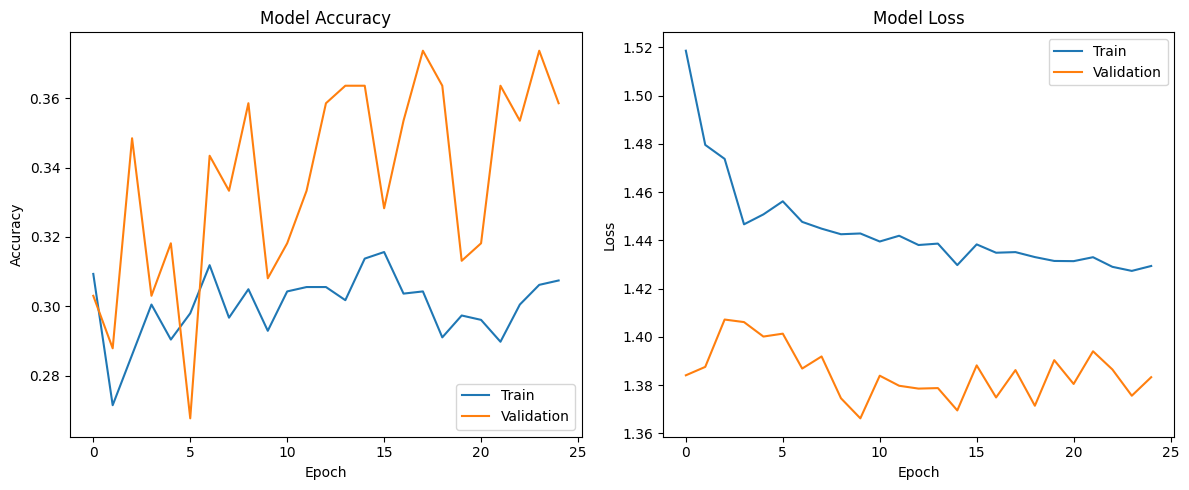

In [ ]:
# Prepare features for different time scales
# Daily features
daily_df = stock.copy()
daily_scaler = StandardScaler()
daily_close = daily_scaler.fit_transform(stock_close.values.reshape(-1, 1)).flatten()
daily_volume = daily_scaler.fit_transform(stock.Volume.values.reshape(-1, 1)).flatten()
daily_df['SMA5'] = stock_close.rolling(window=5).mean()
daily_df['SMA20'] = stock_close.rolling(window=20).mean()
daily_sma5 = daily_scaler.fit_transform(daily_df['SMA5'].fillna(0).values.reshape(-1, 1)).flatten()
daily_sma20 = daily_scaler.fit_transform(daily_df['SMA20'].fillna(0).values.reshape(-1, 1)).flatten()
daily_features = np.column_stack((daily_close, daily_volume, daily_sma5, daily_sma20))

# Weekly features (7-day resampling)
# Create a weekly group identifier
stock['Week'] = stock.index.to_period('W')

# Aggregate
weekly_data = []
for week, group in stock.groupby('Week'):
    weekly_data.append({
        'Week': week.start_time,  # Use the start of the week as the date
        'Open': group['Open'].iloc[0],
        'High': group['High'].max(),
        'Low': group['Low'].min(),
        'Close': group['Close'].iloc[-1],
        'Volume': group['Volume'].sum()
    })

weekly_df = pd.DataFrame(weekly_data).set_index('Week')

# Now proceed with scaling and SMA calculation
weekly_close = weekly_df['Close']
weekly_scaler = StandardScaler()
weekly_close_scaled = weekly_scaler.fit_transform(weekly_close.values.reshape(-1, 1)).flatten()
weekly_volume = weekly_scaler.fit_transform(weekly_df.Volume.values.reshape(-1, 1)).flatten()
weekly_df['SMA4'] = weekly_close.rolling(window=4).mean()
weekly_df['SMA4'] = weekly_df['SMA4'].fillna(0)
weekly_sma4 = weekly_scaler.fit_transform(weekly_df['SMA4'].values.reshape(-1, 1)).flatten()
weekly_features = np.column_stack((weekly_close_scaled, weekly_volume, weekly_sma4))


# Same as prior but for Monthly features
# Create a monthly group identifier
stock['Month'] = stock.index.to_period('M')
monthly_data = []
for month, group in stock.groupby('Month'):
    monthly_data.append({
        'Month': month.start_time,  # Use the start of the month as the date
        'Open': group['Open'].iloc[0],
        'High': group['High'].max(),
        'Low': group['Low'].min(),
        'Close': group['Close'].iloc[-1],
        'Volume': group['Volume'].sum()
    })
monthly_df = pd.DataFrame(monthly_data).set_index('Month')
monthly_close = monthly_df['Close']
monthly_scaler = StandardScaler()
monthly_close_scaled = monthly_scaler.fit_transform(monthly_close.values.reshape(-1, 1)).flatten()
monthly_volume = monthly_scaler.fit_transform(monthly_df.Volume.values.reshape(-1, 1)).flatten()
monthly_features = np.column_stack((monthly_close_scaled, monthly_volume))


# Create mapping from daily index to weekly and monthly features
def map_to_weekly_index(daily_date, weekly_dates):
    # Find the latest weekly data point that's before or equal to this daily date
    valid_dates = weekly_dates[weekly_dates <= daily_date]
    if len(valid_dates) == 0:
        return 0  # Use the first weekly data point if no valid one found
    return weekly_dates.get_loc(valid_dates[-1])

def map_to_monthly_index(daily_date, monthly_dates):
    # Find the latest monthly data point that's before or equal to this daily date
    valid_dates = monthly_dates[monthly_dates <= daily_date]
    if len(valid_dates) == 0:
        return 0  # Use the first monthly data point if no valid one found
    return monthly_dates.get_loc(valid_dates[-1])

# Build index mapping
daily_to_weekly = [map_to_weekly_index(date, weekly_df.index) for date in stock.index]
daily_to_monthly = [map_to_monthly_index(date, monthly_df.index) for date in stock.index]

# Function to create windowed data for all time scales
def create_multi_timescale_data(daily_features, weekly_features, monthly_features,
                             daily_to_weekly, daily_to_monthly, labels,
                             daily_window=20, weekly_window=4, monthly_window=3,
                             validation_split=0.1, test_split=0.1):
    x_daily = []
    x_weekly = []
    x_monthly = []
    y = []

    # Skip initial days to ensure we have enough history
    start_idx = max(30, daily_window)

    for i in range(start_idx, len(daily_features)):
        # Daily features window
        x_daily.append(daily_features[i-daily_window:i])

        # Weekly features window
        weekly_idx = daily_to_weekly[i]
        if weekly_idx >= weekly_window:
            x_weekly.append(weekly_features[weekly_idx-weekly_window:weekly_idx])
        else:
            # Pad with the earliest available data if not enough history
            padding = np.tile(weekly_features[0], (weekly_window-weekly_idx, 1))
            x_weekly.append(np.vstack((padding, weekly_features[:weekly_idx])))

        # Monthly features window
        monthly_idx = daily_to_monthly[i]
        if monthly_idx >= monthly_window:
            x_monthly.append(monthly_features[monthly_idx-monthly_window:monthly_idx])
        else:
            # Pad with the earliest available data if not enough history
            padding = np.tile(monthly_features[0], (monthly_window-monthly_idx, 1))
            x_monthly.append(np.vstack((padding, monthly_features[:monthly_idx])))

        # Label
        y.append(labels[i])

    # Convert to arrays
    x_daily = np.array(x_daily)
    x_weekly = np.array(x_weekly)
    x_monthly = np.array(x_monthly)
    y = np.array(y)

    # Calculate split points
    train_size = int((1 - validation_split - test_split) * len(x_daily))
    val_size = int(validation_split * len(x_daily))

    # Split data
    x_train_daily = x_daily[:train_size]
    x_train_weekly = x_weekly[:train_size]
    x_train_monthly = x_monthly[:train_size]
    y_train = y[:train_size]

    x_val_daily = x_daily[train_size:train_size+val_size]
    x_val_weekly = x_weekly[train_size:train_size+val_size]
    x_val_monthly = x_monthly[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    x_test_daily = x_daily[train_size+val_size:]
    x_test_weekly = x_weekly[train_size+val_size:]
    x_test_monthly = x_monthly[train_size+val_size:]
    y_test = y[train_size+val_size:]

    return (x_train_daily, x_train_weekly, x_train_monthly, y_train,
            x_val_daily, x_val_weekly, x_val_monthly, y_val,
            x_test_daily, x_test_weekly, x_test_monthly, y_test)

# Create multi-timescale windowed data
daily_window = 20
weekly_window = 4
monthly_window = 3

(x_train_daily, x_train_weekly, x_train_monthly, y_train,
 x_val_daily, x_val_weekly, x_val_monthly, y_val,
 x_test_daily, x_test_weekly, x_test_monthly, y_test) = create_multi_timescale_data(
    daily_features, weekly_features, monthly_features,
    daily_to_weekly, daily_to_monthly, mapped_action,
    daily_window=daily_window, weekly_window=weekly_window, monthly_window=monthly_window,
    validation_split=0.1, test_split=0.1)

# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes=classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=classes)

# Build the multi-timescale model

daily_input = Input(shape=(daily_window, daily_features.shape[1]), name='daily_input')
daily_lstm1 = LSTM(256, return_sequences=True)(daily_input)
daily_lstm1 = Dropout(0.2)(daily_lstm1)
daily_lstm2 = LSTM(128, return_sequences=True)(daily_lstm1)
daily_lstm2 = Dropout(0.2)(daily_lstm2)
daily_lstm3 = LSTM(64, return_sequences=True)(daily_lstm2)
daily_lstm3 = Dropout(0.2)(daily_lstm3)
daily_lstm4 = LSTM(32, return_sequences=False)(daily_lstm3)
daily_output = Dropout(0.2)(daily_lstm4)

# 2. Weekly model
weekly_input = Input(shape=(weekly_window, weekly_features.shape[1]), name='weekly_input')
weekly_lstm1 = LSTM(64, return_sequences=True)(weekly_input)
weekly_lstm1 = Dropout(0.2)(weekly_lstm1)
weekly_lstm2 = LSTM(32, return_sequences=False)(weekly_lstm1)
weekly_output = Dropout(0.2)(weekly_lstm2)

# 3. Monthly model
monthly_input = Input(shape=(monthly_window, monthly_features.shape[1]), name='monthly_input')
monthly_lstm1 = LSTM(32, return_sequences=True)(monthly_input)
monthly_lstm1 = Dropout(0.2)(monthly_lstm1)
monthly_lstm2 = LSTM(16, return_sequences=False)(monthly_lstm1)
monthly_output = Dropout(0.2)(monthly_lstm2)

# Combine all time scales
combined = Concatenate()([daily_output, weekly_output, monthly_output])
dense1 = Dense(64, activation='relu')(combined)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(32, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
main_output = Dense(classes, activation='softmax')(dense2)

# Create and compile model
model = Model(inputs=[daily_input, weekly_input, monthly_input], outputs=main_output)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    f'best_{stock_ticker}_multi_timescale_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    [x_train_daily, x_train_weekly, x_train_monthly], y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=([x_val_daily, x_val_weekly, x_val_monthly], y_val_cat),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(
    [x_test_daily, x_test_weekly, x_test_monthly], y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions and analyze results
y_pred_probs = model.predict([x_test_daily, x_test_weekly, x_test_monthly])
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# 3. IMDB Text Classification

In this next lab, you will create a text classification using LSTMs.

In [ ]:
from keras import preprocessing
from keras.datasets import imdb

In [ ]:
# Load imdb dataset and print a few samples to check.
#
# IMDB: sentence (x) -> positive/negative (y)
#
# “The food was really good”                             -> pos
# “The chicken crossed the road because it was uncooked” -> neg

num_words = 10000
maxlen = 100
embedded_size = 16

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
d = imdb.get_word_index()
for w in d:
    if d[w] == 22:
        print(w)
        break

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
you


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [ ]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

x_train has a size (training_size, ). Because the sentences have variable size, we cannot represent this in matrix format.

The first step is to make the column size constant. We do that by "padding" the sentences. If the sentences are bigger, we clip them. If they are smaller, we insert a "NO_WORD" token to the sentence.

In [ ]:
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
x_train.shape, x_test.shape

((25000, 100), (25000, 100))

In [ ]:
x_train[0]

array([1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
        407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,  256,
          4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
         26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
          4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
        194, 7486,   18,    4,  226,   22,   21,  134,  476,   26,  480,
          5,  144,   30, 5535,   18,   51,   36,   28,  224,   92,   25,
        104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
          5,   16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,
         32], dtype=int32)

In [ ]:
def CreateModel(i_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.Embedding(num_words, embedded_size,
                               input_length=maxlen)(x_i)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(500, activation='relu')(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

model = CreateModel(x_train.shape[1:])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         800,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961,001 (3.67 MB)

 Trainable params: 961,001 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.6074 - loss: 0.6290 - val_acc: 0.8348 - val_loss: 0.3640
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8746 - loss: 0.2978 - val_acc: 0.8450 - val_loss: 0.3543
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9250 - loss: 0.1902 - val_acc: 0.8416 - val_loss: 0.3825
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9513 - loss: 0.1265 - val_acc: 0.8352 - val_loss: 0.4370
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9611 - loss: 0.0995 - val_acc: 0.8310 - val_loss: 0.4933
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9676 - loss: 0.0830 - val_acc: 0.8346 - val_loss: 0.5224
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9709 - loss: 0.0742 - val_acc: 0.8362 - val_loss: 0.5312
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9791 - loss: 0.0565 - val_acc: 0.8356 - val_loss: 0.5709
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - a

In [ ]:
eval_result = model.evaluate(x_test, y_test)
eval_result[1]

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8282 - loss: 0.6969


0.829479992389679

- What's the current accuracy for this model?

The current accuracy for this model is around 83% on the test set.

- Try to add a preloaded embedded from Glove from this model, see the
suggestion in https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
- Question: why does this model may help you get better accuracy?

This model might get better accuracy because it has a higher dimensional embedding, which can allow for a better relational representation between the different word vectors.

- Try using an LSTM instead of the models above.

In [ ]:
import os

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 204155 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(d) + 1, 100))
for word, i in d.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(d) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
def CreateModel(i_shape):
    x_i = keras.layers.Input(i_shape)
    x = embedding_layer(x_i)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(500, activation='relu')(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

model = CreateModel(x_train.shape[1:])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       8,858,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │       5,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,859,501 (52.87 MB)

 Trainable params: 5,001,001 (19.08 MB)

 Non-trainable params: 8,858,500 (33.79 MB)

In [ ]:
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - acc: 0.4973 - loss: 0.9858 - val_acc: 0.4936 - val_loss: 0.6932
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - acc: 0.5068 - loss: 0.6932 - val_acc: 0.4932 - val_loss: 0.6929
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - acc: 0.5168 - loss: 0.6915 - val_acc: 0.5076 - val_loss: 0.7114
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - acc: 0.5717 - loss: 0.6766 - val_acc: 0.5420 - val_loss: 0.6926
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - acc: 0.6204 - loss: 0.6500 - val_acc: 0.5634 - val_loss: 0.6858
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 119ms/step - acc: 0.6428 - loss: 0.6301 - val_acc: 0.5694 - val_loss: 0.6839
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - acc: 0.6617 - loss: 0.6143 - val_acc: 0.5694 - val_loss: 0.6887
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - acc: 0.6648 - loss: 0.6086 - val_acc: 0.5688 - val_loss: 0.6969
Epoch 9/20
313/313 ━━━━━━━━━━━━━

In [ ]:
eval_result = model.evaluate(x_test, y_test)
eval_result[1]

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.5627 - loss: 0.7854


0.5602399706840515

In [ ]:
def CreateModel(i_shape):
    x_i = keras.layers.Input(i_shape)
    x = embedding_layer(x_i)
    x = keras.layers.SpatialDropout1D(0.5)(x)
    x = keras.layers.LSTM(32)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

model = CreateModel(x_train.shape[1:])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       8,858,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,875,557 (33.86 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 8,858,500 (33.79 MB)

In [ ]:
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - acc: 0.5128 - loss: 0.6995 - val_acc: 0.5548 - val_loss: 0.6844
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - acc: 0.5393 - loss: 0.6874 - val_acc: 0.5620 - val_loss: 0.6792
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - acc: 0.5525 - loss: 0.6835 - val_acc: 0.5824 - val_loss: 0.6713
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - acc: 0.5621 - loss: 0.6760 - val_acc: 0.6058 - val_loss: 0.6555
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - acc: 0.5857 - loss: 0.6653 - val_acc: 0.6126 - val_loss: 0.6409
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - acc: 0.6061 - loss: 0.6538 - val_acc: 0.6530 - val_loss: 0.6165
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - acc: 0.6273 - loss: 0.6409 - val_acc: 0.6492 - val_loss: 0.6162
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - acc: 0.6401 - loss: 0.6282 - val_acc: 0.6654 - val_loss: 0.6013
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 

# 4. Generate Text from Nietzsche's Writings

In this example, you will generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.

In [ ]:
path = keras.utils.get_file("nietzsche.txt",
        origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

text = open(path).read().lower()
print("corpus length:", len(text))

600901/600901 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
corpus length: 600893


In [ ]:
print(text[:1000])

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to truth, have been unskilled and unseemly methods for
winning a woman? certainly she has never allowed herself to be won; and
at present every kind of dogma stands with sad and discouraged mien--if,
indeed, it stands at all! for there are scoffers who maintain that it
has fallen, that all dogma lies on the ground--nay more, that it is at
its last gasp. but to speak seriously, there are good grounds for hoping
that all dogmatizing in philosophy, whatever solemn, whatever conclusive
and decided airs it has assumed, may have been only a noble puerilism
and tyronism; and probably the time is at hand when it will be once
and again understood what has actually sufficed for the basis of such
imposing and abso

In [ ]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57


In [ ]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 200265


In [ ]:
print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.int8)
y = np.zeros((len(sentences), len(chars)), dtype=np.int8)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [ ]:
# build the model: 2 stacked LSTM
print("Build model...")
xi = keras.layers.Input((maxlen, len(chars)))
x = keras.layers.GRU(256, return_sequences=True)(xi)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(chars))(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs=xi, outputs=x)
model.summary()

Build model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 57)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 256)            │         241,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 57)                  │          14,649 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 57)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,321 (2.48 MB)

 Trainable params: 651,321 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(0.003)

model.compile(loss="categorical_crossentropy", optimizer=adam)

In [ ]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
      error = 1.0 - np.sum(a)
      a[0] += error
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [ ]:
import sys

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=4096, epochs=4)
    model.save_weights("model.weights.h5")

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print("----- Generating with seed: '" + sentence + "'")
        sys.stdout.write(generated)

        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            # predict next char
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # full sentence being generated
            generated += next_char

            # shift sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()

            # let's consider only one sentence
            if next_char == ".":
              break
        print()


--------------------------------------------------
Iteration 1
Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 613ms/step - loss: 3.1860
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 643ms/step - loss: 2.3221
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 679ms/step - loss: 2.0938
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 698ms/step - loss: 1.9373

----- diversity: 0.2
----- Generating with seed: 'ighest wisdom concerning things in [mere] words; and, in truth,
language is the first movement in al'
ighest wisdom concerning things in [mere] words; and, in truth,
language is the first movement in all the for the prosent of the sould and the still and and and and and as the strengs and and and and and and its and and and and and in the some and and the prosent of the precopsion of the probed of t

----- diversity: 0.5
----- Generating with seed: 'ighest wisdom concerning things in [mere] words; and, in truth,
language is the first movement in al'
ighest wisdom concerning things in [mere] words; and, in trut

- Pick up one set of data samples from linux kernel source code (https://github.com/torvalds/linux)
- Modify the model to be trained in the corpus
- Present the results

In [ ]:
path = "memory-barriers.txt"

text = open(path).read().lower()
print("corpus length:", len(text))

corpus length: 114178


In [ ]:
print(text[:1000])

			 linux kernel memory barriers

by: david howells <dhowells@redhat.com>
    paul e. mckenney <paulmck@linux.ibm.com>
    will deacon <will.deacon@arm.com>
    peter zijlstra <peterz@infradead.org>

disclaimer

this document is not a specification; it is intentionally (for the sake of
brevity) and unintentionally (due to being human) incomplete. this document is
meant as a guide to using the various memory barriers provided by linux, but
in case of any doubt (and there are many) please ask.  some doubts may be
resolved by referring to the formal memory consistency model and related
documentation at tools/memory-model/.  nevertheless, even this memory
model should be viewed as the collective opinion of its maintainers rather
than as an infallible oracle.

to repeat, this document is not a specification of what linux expects from
hardware.

the purpose of this document is twofold:

 (1) to specify th


In [ ]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 70


In [ ]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 38026


In [ ]:
import numpy as np

print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.int8)
y = np.zeros((len(sentences), len(chars)), dtype=np.int8)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [ ]:
from tensorflow import keras

# build the model: 2 stacked LSTM
print("Build model...")
xi = keras.layers.Input((maxlen, len(chars)))
x = keras.layers.GRU(256, return_sequences=True)(xi)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(chars))(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs=xi, outputs=x)
model.summary()

Build model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 70)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 256)            │         251,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 70)                  │          17,990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 70)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,646 (2.54 MB)

 Trainable params: 664,646 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(0.003)

model.compile(loss="categorical_crossentropy", optimizer=adam)

In [ ]:
import sys

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=4096, epochs=4)
    model.save_weights("model.weights.h5")

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print("----- Generating with seed: '" + sentence + "'")
        sys.stdout.write(generated)

        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            # predict next char
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # full sentence being generated
            generated += next_char

            # shift sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()

            # let's consider only one sentence
            if next_char == ".":
              break
        print()


--------------------------------------------------
Iteration 1
Epoch 1/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - loss: 3.8842
Epoch 2/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 563ms/step - loss: 3.0441
Epoch 3/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 570ms/step - loss: 2.8692
Epoch 4/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - loss: 2.7272

----- diversity: 0.2
----- Generating with seed: ' between the load
from 'a' and the store to 'c'.  the control dependencies would extend
only to the '
 between the load
from 'a' and the store to 'c'.  the control dependencies would extend
only to the                                                                                                                                                                                                         

----- diversity: 0.5
----- Generating with seed: ' between the load
from 'a' and the store to 'c'.  the control dependencies would extend
only to the '
 between the load
from 'a' and the store to 'c'.  the control d